In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib
from docplex.mp.model import Model
from copy import deepcopy

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
inputs = pd.read_excel('NurseAssignment_data.xlsx', sheet_name=None)
inputs.keys()

dict_keys(['Departments', 'Skills', 'Shifts', 'SkillRequirements', 'Nurses', 'NurseSkills', 'NurseVacations', 'NurseAssociations', 'NurseIncompatibilities'])

In [3]:
df_skills = inputs['Skills']
df_depts = inputs['Departments']
df_shifts = inputs['Shifts']
# Rename df_shifts index
df_shifts.index.name = 'shiftId'

# Index is column 0: name
#df_nurses = nurse_xls_file.parse('Nurses', header=0, index_col=0)
df_nurses = inputs['Nurses'].set_index('name')
df_nurse_skills = inputs['NurseSkills']
df_vacations = inputs['NurseVacations']
df_associations = inputs['NurseAssociations']
df_incompatibilities = inputs['NurseIncompatibilities']



# maximum work time (in hours)
max_work_time = 40

# maximum number of shifts worked in a week.
max_nb_shifts = 5

# Create Dvs

In [4]:
mdl = Model('Nurse')

In [5]:
all_nurses = df_nurses.index.values
all_shifts = df_shifts.index.values

# the assignment variables.
assigned = mdl.binary_var_matrix(keys1=all_nurses, keys2=all_shifts, name="assign_%s_%s")

def make_var(row, varname_fmt):
    return mdl.continuous_var(name=varname_fmt % row.name, lb=0)

# add two extra variables per nurse: deviations above and below average
df_nurses["worked"]      = df_nurses.apply(lambda r: make_var(r, "IsWorked%s"), axis=1)
df_nurses["overworked"]  = df_nurses.apply(lambda r: make_var(r, "OverWorked_%s"), axis=1)
df_nurses["underworked"] = df_nurses.apply(lambda r: make_var(r, "UnderWorked_%s"), axis=1)

 # auxiliary function to create worktime variable from a row
def make_var(row, varname_fmt):
    return mdl.continuous_var(name=varname_fmt % row.name, lb=0)

# apply the function over nurse rows and store result in a new column
df_nurses["worktime"] = df_nurses.apply(lambda r: make_var(r, "worktime_%s"), axis=1)

In [6]:
df_nurses.head(4)

,seniority,qualification,pay_rate,worked,overworked,underworked,worktime
name,,,,,,,
Anne,11,1,25,IsWorkedAnne,OverWorked_Anne,UnderWorked_Anne,worktime_Anne
Bethanie,4,5,28,IsWorkedBethanie,OverWorked_Bethanie,UnderWorked_Bethanie,worktime_Bethanie
Betsy,2,2,17,IsWorkedBetsy,OverWorked_Betsy,UnderWorked_Betsy,worktime_Betsy
Cathy,2,2,17,IsWorkedCathy,OverWorked_Cathy,UnderWorked_Cathy,worktime_Cathy


# Create Constraints

## Overlapping shifts

Some shifts overlap in time, and thus cannot be assigned to the same nurse. To check whether two shifts overlap in time, 
we start by ordering all shifts with respect to their wstart and duration properties. Then, for each shift, 
we iterate over the subsequent shifts in this ordered list to easily compute the subset of overlapping shifts.
We use pandas operations to implement this algorithm. But first, we organize all decision variables in a DataFrame.
convenience, we also organize the decision variables in a pivot table with nurses as row index and shifts as columns. 
The pandas unstack operation does this.


Prepare Shift Table

In [7]:

days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
day_of_weeks = dict(zip(days, range(7)))

# utility to convert a day string e.g. "Monday" to an integer in 0..6
def day_to_day_of_week(day):
    return day_of_weeks[day.strip().lower()]

# for each day name, we normalize it by stripping whitespace and converting it to lowercase
# " Monday" -> "monday"
df_shifts["dow"] = df_shifts.day.apply(day_to_day_of_week)

# Computing the start time in the week is easy: just add 24*dow to column start_time. The result is stored in a new column wstart.
df_shifts["wstart"] =df_shifts.start_time + 24 * df_shifts.dow

# Computing the absolute end time is a little more complicated as certain shifts span across midnight. 
# For example, Shift #3 starts on Monday at 18:00 and ends Tuesday at 2:00 AM. The absolute end time of Shift #3 is 26, not 2. 
# The general rule for computing absolute end time is:
# abs_end_time = end_time + 24 * dow + (start_time>= end_time ? 24 : 0)

#Again, we use pandas to add a new calculated column wend. This is done by using the pandas apply method with an anonymous lambda function over rows. 
# The raw=True parameter prevents the creation of a pandas Series for each row, which improves the performance significantly on large data sets.

# an auxiliary function to calculate absolute end time of a shift
def calculate_absolute_endtime(start, end, dow):
    return 24*dow + end + (24 if start>=end else 0)

# store the results in a new column
df_shifts["wend"] = df_shifts.apply(lambda row: calculate_absolute_endtime(
        row.start_time, row.end_time, row.dow), axis=1)


#Computing the duration of each shift is now a straightforward difference of columns. The result is stored in column duration.
df_shifts["duration"] = df_shifts.wend - df_shifts.wstart

#Minimum demand is the product of duration (in hours) by the minimum required number of nurses. 
# Thus, in number of nurse-hours, this demand is stored in another new column min_demand.

# also compute minimum demand in nurse-hours
df_shifts["min_demand"] = df_shifts.min_req * df_shifts.duration

df_shifts.head(3)

,department,day,start_time,end_time,min_req,max_req,dow,wstart,wend,duration,min_demand
shiftId,,,,,,,,,,,
0,Emergency,Monday,2,8,3,5,0,2,8,6,18
1,Emergency,Monday,8,12,4,7,0,8,12,4,16
2,Emergency,Monday,12,18,2,5,0,12,18,6,12


In [8]:
df_assigned = pd.DataFrame({'assigned': assigned})
df_assigned.index.names=['all_nurses', 'all_shifts']

# Re-organize the Data Frame as a pivot table with nurses as row index and shifts as columns:
df_assigned_pivot = df_assigned.unstack(level='all_shifts')

#We create a DataFrame representing a list of shifts sorted by "wstart" and "duration". 
# This sorted list will be used to easily detect overlapping shifts.
# Note that indices are reset after sorting so that the DataFrame can be indexed with respect to the index in the sorted 
# list and not the original unsorted list. This is the purpose of the reset_index() operation which also adds a new column named 
# "shiftId" with the original index.

# Create a Data Frame representing a list of shifts sorted by wstart and duration.
# One keeps only the three relevant columns: 'shiftId', 'wstart' and 'wend' in the resulting Data Frame 
df_sorted_shifts = df_shifts.sort_values(['wstart','duration']).reset_index()[['shiftId', 'wstart', 'wend']]

#Next, we state that for any pair of shifts that overlap in time, a nurse can be assigned to only one of the two.

number_of_incompatible_shift_constraints = 0
for shift in df_sorted_shifts.itertuples():
    # Iterate over following shifts
    # 'shift[0]' contains the index of the current shift in the df_sorted_shifts Data Frame
    for shift_2 in df_sorted_shifts.iloc[shift[0] + 1:].itertuples():
        if (shift_2.wstart < shift.wend):
            # Iterate over all nurses to force incompatible assignment for the current pair of overlapping shifts
            for nurse_assignments in df_assigned_pivot.iloc[:, [shift.shiftId, shift_2.shiftId]].itertuples():
                # this is actually a logical OR
                mdl.add_constraint(nurse_assignments[1] + nurse_assignments[2] <= 1)
                number_of_incompatible_shift_constraints += 1
        else:
            # No need to test overlap with following shifts
            break
print("#incompatible shift constraints: {}".format(number_of_incompatible_shift_constraints))

#incompatible shift constraints: 640


## Vacations_constraint

When the nurse is on vacation, he cannot be assigned to any shift starting that day.
        We use the pandas merge operation to create a join between the "df_vacations", "df_shifts", and "df_assigned" DataFrames. 
        Each row of the resulting DataFrame contains the assignment decision variable corresponding to the matching (nurse, shift) pair.

In [9]:

days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
day_of_weeks = dict(zip(days, range(7)))
def day_to_day_of_week(day):
    return day_of_weeks[day.strip().lower()]

# Add 'day of week' column to vacations Data Frame
df_vacations['dow'] = df_vacations.day.apply(day_to_day_of_week)

# Join 'df_vacations', 'df_shifts' and 'df_assigned' Data Frames to create the list of 'forbidden' assigments.
# The 'reset_index()' function is invoked to move 'shiftId' index as a column in 'df_shifts' Data Frame, and
# to move the index pair ('all_nurses', 'all_shifts') as columns in 'df_assigned' Data Frame.
# 'reset_index()' is invoked so that a join can be performed between Data Frame, based on column names.
df_assigned_reindexed = df_assigned.reset_index()
df_vacation_forbidden_assignments = df_vacations.merge(df_shifts.reset_index()[['dow', 'shiftId']]).merge(
    df_assigned_reindexed, left_on=['nurse', 'shiftId'], right_on=['all_nurses', 'all_shifts'])

for forbidden_assignment in df_vacation_forbidden_assignments.itertuples():
    # to forbid an assignment just set the variable to zero.
    mdl.add_constraint(forbidden_assignment.assigned == 0)
print("# vacation forbids: {} assignments".format(len(df_vacation_forbidden_assignments)))

# vacation forbids: 350 assignments


## Associations_constraints

Some pairs of nurses get along particularly well, so we wish to assign them together as a team. In other words, for every such couple and for each shift, both assignment variables should always be equal. 
        Either both nurses work the shift, or both do not.
        In the same way we modeled vacations, we use the pandas merge operation to create a DataFrame for which each row contains the pair of 
        nurse-shift assignment decision variables matching each association.

In [10]:
# Join 'df_assignment' Data Frame twice, based on associations to get corresponding decision variables pairs for all shifts
# The 'suffixes' parameter in the second merge indicates our preference for updating the name of columns that occur both
# in the first and second argument Data Frames (in our case, these columns are 'all_nurses' and 'assigned').
df_preferred_assign = df_associations.merge(
    df_assigned_reindexed, left_on='nurse1', right_on='all_nurses').merge(
    df_assigned_reindexed, left_on=['nurse2', 'all_shifts'], right_on=['all_nurses', 'all_shifts'], suffixes=('_1','_2'))
# The associations constraint can now easily be formulated by iterating on the rows of the "df_preferred_assign" DataFrame.

for preferred_assign in df_preferred_assign.itertuples():
    mdl.add_constraint(preferred_assign.assigned_1 == preferred_assign.assigned_2)


## Incompatibilities_constraints

Similarly, certain pairs of nurses do not get along well, and we want to avoid having them together on a shift. 
        In other terms, for each shift, both nurses of an incompatible pair cannot be assigned together to the sift. Again, 
        we state a logical OR between the two assignments: at most one nurse from the pair can work the shift.
        We first create a DataFrame whose rows contain pairs of invalid assignment decision variables, 
        using the same pandas merge operations as in the previous step.

In [11]:
# Join assignment Data Frame twice, based on incompatibilities Data Frame to get corresponding decision variables pairs
#  for all shifts

df_incompatible_assign = df_incompatibilities.merge(
    df_assigned_reindexed, left_on='nurse1', right_on='all_nurses').merge(
    df_assigned_reindexed, left_on=['nurse2', 'all_shifts'], right_on=['all_nurses', 'all_shifts'], suffixes=('_1','_2'))

#The incompatibilities constraint can now easily be formulated, by iterating on the rows of the "df_incompatible_assign" DataFrame.
for incompatible_assign in df_incompatible_assign.itertuples():
    mdl.add_constraint(incompatible_assign.assigned_1 + incompatible_assign.assigned_2 <= 1)

## worktime_constranit

Define total work time
Work time variables must be constrained to be equal to the sum of hours actually worked.    
We use the pandas groupby operation to collect all assignment decision variables for each nurse in a separate series. 
Then, we iterate over nurses to post a constraint calculating the actual worktime for each nurse as the dot product of the 
series of nurse-shift assignments with the series of shift durations.        

In [12]:

# Use pandas' groupby operation to enforce constraint calculating worktime for each nurse as the sum of all assigned
#  shifts times the duration of each shift
for nurse, nurse_assignments in df_assigned.groupby(level='all_nurses'):
    mdl.add_constraint(df_nurses.worktime[nurse] == mdl.dot(nurse_assignments.assigned, df_shifts.duration))

## min_Max_work_time_constraints

For each nurse, we add a constraint to enforce the maximum work time for a week. 
        Again we use the apply method, this time with an anonymous lambda function.

Minimum requirement for shifts
        Each shift requires a minimum number of nurses. For each shift, the sum over all nurses of 
        assignments to this shift must be greater than the minimum requirement.
        The pandas groupby operation is invoked to collect all assignment decision variables for each shift in a separate series. 
        Then, we iterate over shifts to post the constraint enforcing the minimum number of nurse assignments for each shift.

In [13]:
# we use pandas' apply() method to set an upper bound on all worktime variables.
def set_max_work_time(v):
    v.ub = max_work_time
    # Optionally: return a string for fancy display of the constraint in the Output cell
    return str(v) + ' <= ' + str(v.ub)

df_nurses["worktime"].apply(convert_dtype=False, func=set_max_work_time);

# Use pandas' groupby operation to enforce minimum requirement constraint for each shift
for shift, shift_nurses in df_assigned.groupby(level='all_shifts'):
    mdl.add_constraint(mdl.sum(shift_nurses.assigned) >= df_shifts.min_req[shift])

## fairness_constraints

In [14]:
# Use the pandas groupby operation to enforce the constraint calculating number of worked shifts for each nurse
for nurse, nurse_assignments in df_assigned.groupby(level='all_nurses'):
    # nb of worked shifts is sum of assigned shifts
    mdl.add_constraint(df_nurses.worked[nurse] == sum(nurse_assignments.assigned))
avg_worked = df_shifts["min_req"].sum() / float(len(all_nurses))
for nurse in df_nurses.itertuples():
    # nb worked is average + over - under
    mdl.add_constraint(nurse.worked == avg_worked + nurse.overworked - nurse.underworked)

# create_objectives

The objective mixes different (and contradictory) KPIs.
        The first KPI is the total salary cost, computed as the sum of work times over all nurses, weighted by pay rate.
        We compute this KPI as an expression from the variables we previously defined by using the panda summation over the DOcplex objects.

In [15]:
# again leverage pandas to create a series of expressions: costs of each nurse
total_salary_series = df_nurses.worktime * df_nurses.pay_rate

# compute global salary cost using pandas sum()
# Note that the result is a DOcplex expression: DOcplex if fully compatible with pandas
total_salary_cost = total_salary_series.sum()
mdl.add_kpi(total_salary_cost, "Total salary cost")


# finally, define kpis for over and under average quantities
total_overw = mdl.sum(df_nurses["overworked"])
mdl.add_kpi(total_overw, "Total over-worked")
total_underw = mdl.sum(df_nurses["underworked"])
mdl.add_kpi(total_underw, "Total under-worked")

DecisionKPI(name=Total under-worked,expr=UnderWorked_Anne+UnderWorked_Bethanie+UnderWorked_Betsy+UnderWor..)

In [16]:
df_nurses.head()

,seniority,qualification,pay_rate,worked,overworked,underworked,worktime
name,,,,,,,
Anne,11,1,25,IsWorkedAnne,OverWorked_Anne,UnderWorked_Anne,worktime_Anne
Bethanie,4,5,28,IsWorkedBethanie,OverWorked_Bethanie,UnderWorked_Bethanie,worktime_Bethanie
Betsy,2,2,17,IsWorkedBetsy,OverWorked_Betsy,UnderWorked_Betsy,worktime_Betsy
Cathy,2,2,17,IsWorkedCathy,OverWorked_Cathy,UnderWorked_Cathy,worktime_Cathy
Cecilia,9,5,38,IsWorkedCecilia,OverWorked_Cecilia,UnderWorked_Cecilia,worktime_Cecilia


In [17]:
mdl.print_information()

Model: Nurse
 - number of variables: 1472
   - binary=1344, integer=0, continuous=128
 - number of constraints: 1674
   - linear=1674
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# set_objective

In [18]:
mdl.minimize(total_salary_cost + total_overw + total_underw)
mdl.solve(log_output= True)

mdl.report()

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1010 rows and 388 columns.
MIP Presolve modified 90 coefficients.
Aggregator did 74 substitutions.
Reduced MIP has 590 rows, 1008 columns, and 3940 nonzeros.
Reduced MIP has 914 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (4.39 ticks)
Probing time = 0.00 sec. (0.60 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2 rows and 4 columns.
Reduced MIP has 588 rows, 1004 columns, and 3894 nonzeros.
Reduced MIP has 914 binaries, 30 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.43 ticks)
Probing time = 0.00 sec. (0.60 ticks)
Clique table members: 486.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (11.66 ticks)

        Nodes       

In [19]:
outputs = {}

df_assigned_output= df_assigned.reset_index()
df_assigned_output['assigned_sol'] = df_assigned_output['assigned'].apply(lambda x:x.solution_value)
df_assigned_output = df_assigned_output.set_index(['all_nurses','all_shifts'])
#df_assigned[df_assigned['assigned_sol']>0].
df_assigned_output.head()


assigned  assigned_sol
all_nurses all_shifts                             
Anne       0           assign_Anne_0           0.0
           1           assign_Anne_1           0.0
           2           assign_Anne_2           0.0
           3           assign_Anne_3           1.0
           4           assign_Anne_4           0.0

In [20]:
df_nurses.head(1)

,seniority,qualification,pay_rate,worked,overworked,underworked,worktime
name,,,,,,,
Anne,11,1,25,IsWorkedAnne,OverWorked_Anne,UnderWorked_Anne,worktime_Anne


In [21]:
df_nurses_output = df_nurses
df_nurses_output['worked_sol'] = df_nurses_output['worked'].apply(lambda x:x.solution_value)
df_nurses_output['overworked_sol'] = df_nurses_output['overworked'].apply(lambda x:x.solution_value)
df_nurses_output['underworked_sol'] = df_nurses_output['underworked'].apply(lambda x:x.solution_value)
df_nurses_output['worktime_sol'] = df_nurses_output['worktime'].apply(lambda x:x.solution_value)
df_nurses_output.head()

,seniority,qualification,pay_rate,worked,overworked,underworked,worktime,worked_sol,overworked_sol,underworked_sol,worktime_sol
name,,,,,,,,,,,
Anne,11,1,25,IsWorkedAnne,OverWorked_Anne,UnderWorked_Anne,worktime_Anne,7.0,0.03125,0.0,40.0
Bethanie,4,5,28,IsWorkedBethanie,OverWorked_Bethanie,UnderWorked_Bethanie,worktime_Bethanie,7.0,0.03125,0.0,40.0
Betsy,2,2,17,IsWorkedBetsy,OverWorked_Betsy,UnderWorked_Betsy,worktime_Betsy,7.0,0.03125,0.0,40.0
Cathy,2,2,17,IsWorkedCathy,OverWorked_Cathy,UnderWorked_Cathy,worktime_Cathy,7.0,0.03125,0.0,40.0
Cecilia,9,5,38,IsWorkedCecilia,OverWorked_Cecilia,UnderWorked_Cecilia,worktime_Cecilia,7.0,0.03125,0.0,36.0


In [22]:
df_res = df_assigned_output.assigned_sol.unstack(level='all_shifts')

df_res.head(1)

all_shifts,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
all_nurses,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anne,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Let's analyze how worktime is distributed among nurses.
        # First, we compute the global average work time as the total minimum requirement in hours, divided by number of nurses.
s_demand  = df_shifts.min_req * df_shifts.duration
total_demand = s_demand.sum()
avg_worktime = total_demand / float(len(all_nurses))
print("* theoretical average work time is {0:g} h".format(avg_worktime))

#Let's analyze the series of deviations to the average, stored in a pandas Series.
# a pandas series of worktimes solution values
s_worktime = df_nurses.worktime.apply(lambda v: v.solution_value)

# returns a new series computed as deviation from average
s_to_mean = s_worktime - avg_worktime

# take the absolute value
s_abs_to_mean = s_to_mean.apply(abs)


total_to_mean = s_abs_to_mean.sum()
print("* the sum of absolute deviations from mean is {}".format(total_to_mean))


#Let's now analyze the solution from the number of shifts perspective. 
# How many shifts does each nurse work? Are these shifts fairly distributed amongst nurses?
# We compute a new column in our result DataFrame for the number of shifts worked, 
# by summing rows (the "axis=1" argument in the sum() call indicates to pandas that each sum is performed by row instead of column):

# a pandas series of #shifts worked
df_worked = df_res[all_shifts].sum(axis=1)
df_res["worked"] = df_worked
#We see that one nurse works significantly fewer shifts than others do. What is the average number of shifts worked by a nurse? This is equal to the total demand divided by the number of nurses.
# Of course, this yields a fractional number of shifts that is not practical, but nonetheless will help us quantify the fairness in shift distribution.

avg_worked = df_shifts["min_req"].sum() / float(len(all_nurses))
print("-- expected avg #shifts worked is {}".format(avg_worked))

worked_to_avg = df_res["worked"] - avg_worked
total_to_mean = worked_to_avg.apply(abs).sum()
print("-- total absolute deviation to mean #shifts is {}".format(total_to_mean))

* theoretical average work time is 39.5625 h
* the sum of absolute deviations from mean is 25.375
-- expected avg #shifts worked is 6.96875
-- total absolute deviation to mean #shifts is 1.9375


In [24]:
df_nurses_output.sample(4)

,seniority,qualification,pay_rate,worked,overworked,underworked,worktime,worked_sol,overworked_sol,underworked_sol,worktime_sol
name,,,,,,,,,,,
Janelle,4,3,22,IsWorkedJanelle,OverWorked_Janelle,UnderWorked_Janelle,worktime_Janelle,7.0,0.03125,0.0,40.0
Cathy,2,2,17,IsWorkedCathy,OverWorked_Cathy,UnderWorked_Cathy,worktime_Cathy,7.0,0.03125,0.0,40.0
Roberta,3,5,26,IsWorkedRoberta,OverWorked_Roberta,UnderWorked_Roberta,worktime_Roberta,7.0,0.03125,0.0,40.0
Joan,5,3,24,IsWorkedJoan,OverWorked_Joan,UnderWorked_Joan,worktime_Joan,7.0,0.03125,0.0,40.0


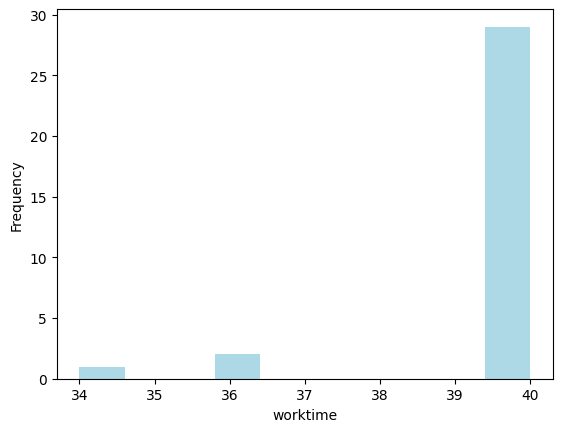

In [25]:
import matplotlib.pyplot as plt
df_nurses_output["worktime_sol"].plot.hist(color='LightBlue');
plt.xlabel("worktime");

Text(0, 0.5, '#shifts worked')

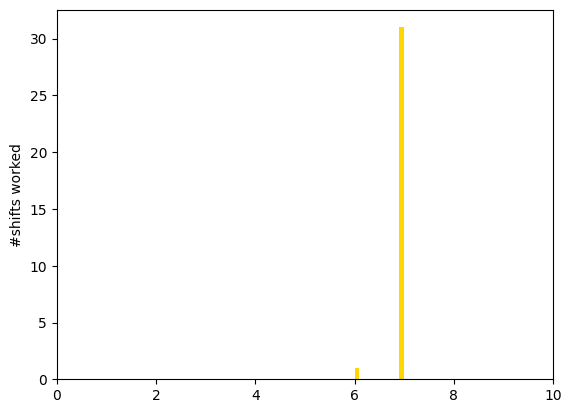

In [26]:
df_res['worked'].plot.hist(color="gold", xlim=(0,10))
plt.ylabel("#shifts worked")

<Axes: ylabel='Frequency'>

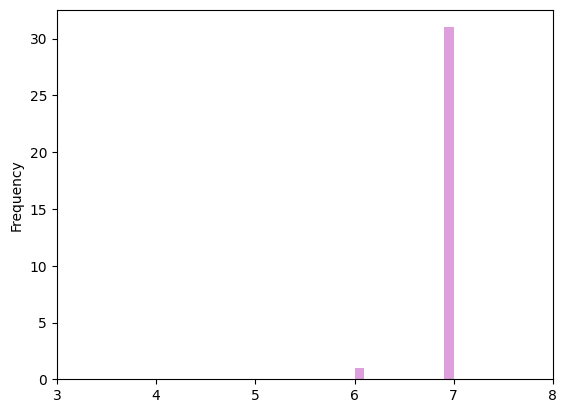

In [27]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned_fair = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res_fair = s_assigned_fair.unstack(level='all_shifts')

# Add a new column to the pivot table containing the #shifts worked by summing over each row
df_res_fair["solution_value_fair"] = df_res_fair[all_shifts].sum(axis=1)
df_res_fair["worked"] = df_res_fair[all_shifts].sum(axis=1)
df_res_fair["worked"].plot.hist(color="plum", xlim=(3,8))